In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.stats import poisson, binom, nbinom, lognorm, pareto, gamma, scoreatpercentile
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score

In [59]:
# Load the claims data file into a DataFrame 
file_path = "claim_data_group4_2024.csv"
claims_data_df = pd.read_csv(file_path)
claims_data_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0
2,72908,0,0.50,E,7,11,67,50,B3,Regular,4762,R93,0.0
3,2283027,0,0.08,B,5,8,28,60,B1,Diesel,64,R91,0.0
4,1123838,0,0.03,A,11,1,38,50,B2,Regular,16,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0
99996,4163362,0,0.22,E,6,13,58,50,B1,Diesel,4762,R93,0.0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0
99998,2012998,0,0.71,D,9,9,36,54,B1,Regular,1541,R91,0.0


In [60]:
# Claim frequency will be used instead for number of claims as the period of exposure, meaning, the time a claim can occur, is also considered.
# Claim severity is the average claim amount per claim and will be used instead of the claim amount. 
claims_data_df['Frequency'] = claims_data_df['ClaimNb'] / claims_data_df['Exposure'] #Number of claims per year
claims_data_df['Severity'] = claims_data_df['ClaimAmount'] / claims_data_df['ClaimNb'] #Amount per claim

# Drop the original columns and place the new columns at the same position as the original columns 
claims_data = claims_data_df.drop(columns=['ClaimNb'])
#claims_data = claims_data[['Frequency','Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'Severity']]

# Fill missing values in the 'Severity' column with 0 (meaning no claim occurred)
claims_data['Severity'] = claims_data['Severity'].fillna(0)

# Descriptive Statistics

In [61]:
def plot_variable(data, group_var, ax_freq, ax_sev):
    """
    Function to plot frequency and severity of claims by policyholder characteristics.
    
    :param data: DataFrame to plot.
    :param group_var: The variable to group by.
    :param ax_freq: The axes object for frequency plots.
    :param ax_sev: The axes object for severity plots.
    """
    # Calculate frequency and severity
    freq = data.groupby(group_var)['Frequency'].sum()
    sev = data[data['Frequency'] > 0].groupby(group_var)['ClaimAmount'].mean()
    
    dollar_formatter = FuncFormatter(lambda x, pos: f'${int(x)}')

    # Plot Frequency
    sns.barplot(x=freq.index, y=freq.values, ax=ax_freq)
    ax_freq.set_title(f'Claim Frequency by {group_var}')
    ax_freq.set_xlabel(group_var)
    ax_freq.set_ylabel('Total Claims')
    ax_freq.tick_params(axis='x')
    if group_var in ['BonusMalus','DrivAge', 'VehAge']:
        ax_freq.xaxis.set_major_locator(MaxNLocator(10))

    # Plot Severity
    sns.barplot(x=sev.index, y=sev.values, ax=ax_sev)
    ax_sev.set_title(f'Claim Severity by {group_var}')
    ax_sev.set_xlabel(group_var)
    ax_sev.set_ylabel('Average Claim Amount')
    ax_sev.tick_params(axis='x')
    ax_sev.yaxis.set_major_formatter(dollar_formatter)
    if group_var in ['BonusMalus', 'DrivAge']:
        ax_sev.xaxis.set_major_locator(MaxNLocator(10))

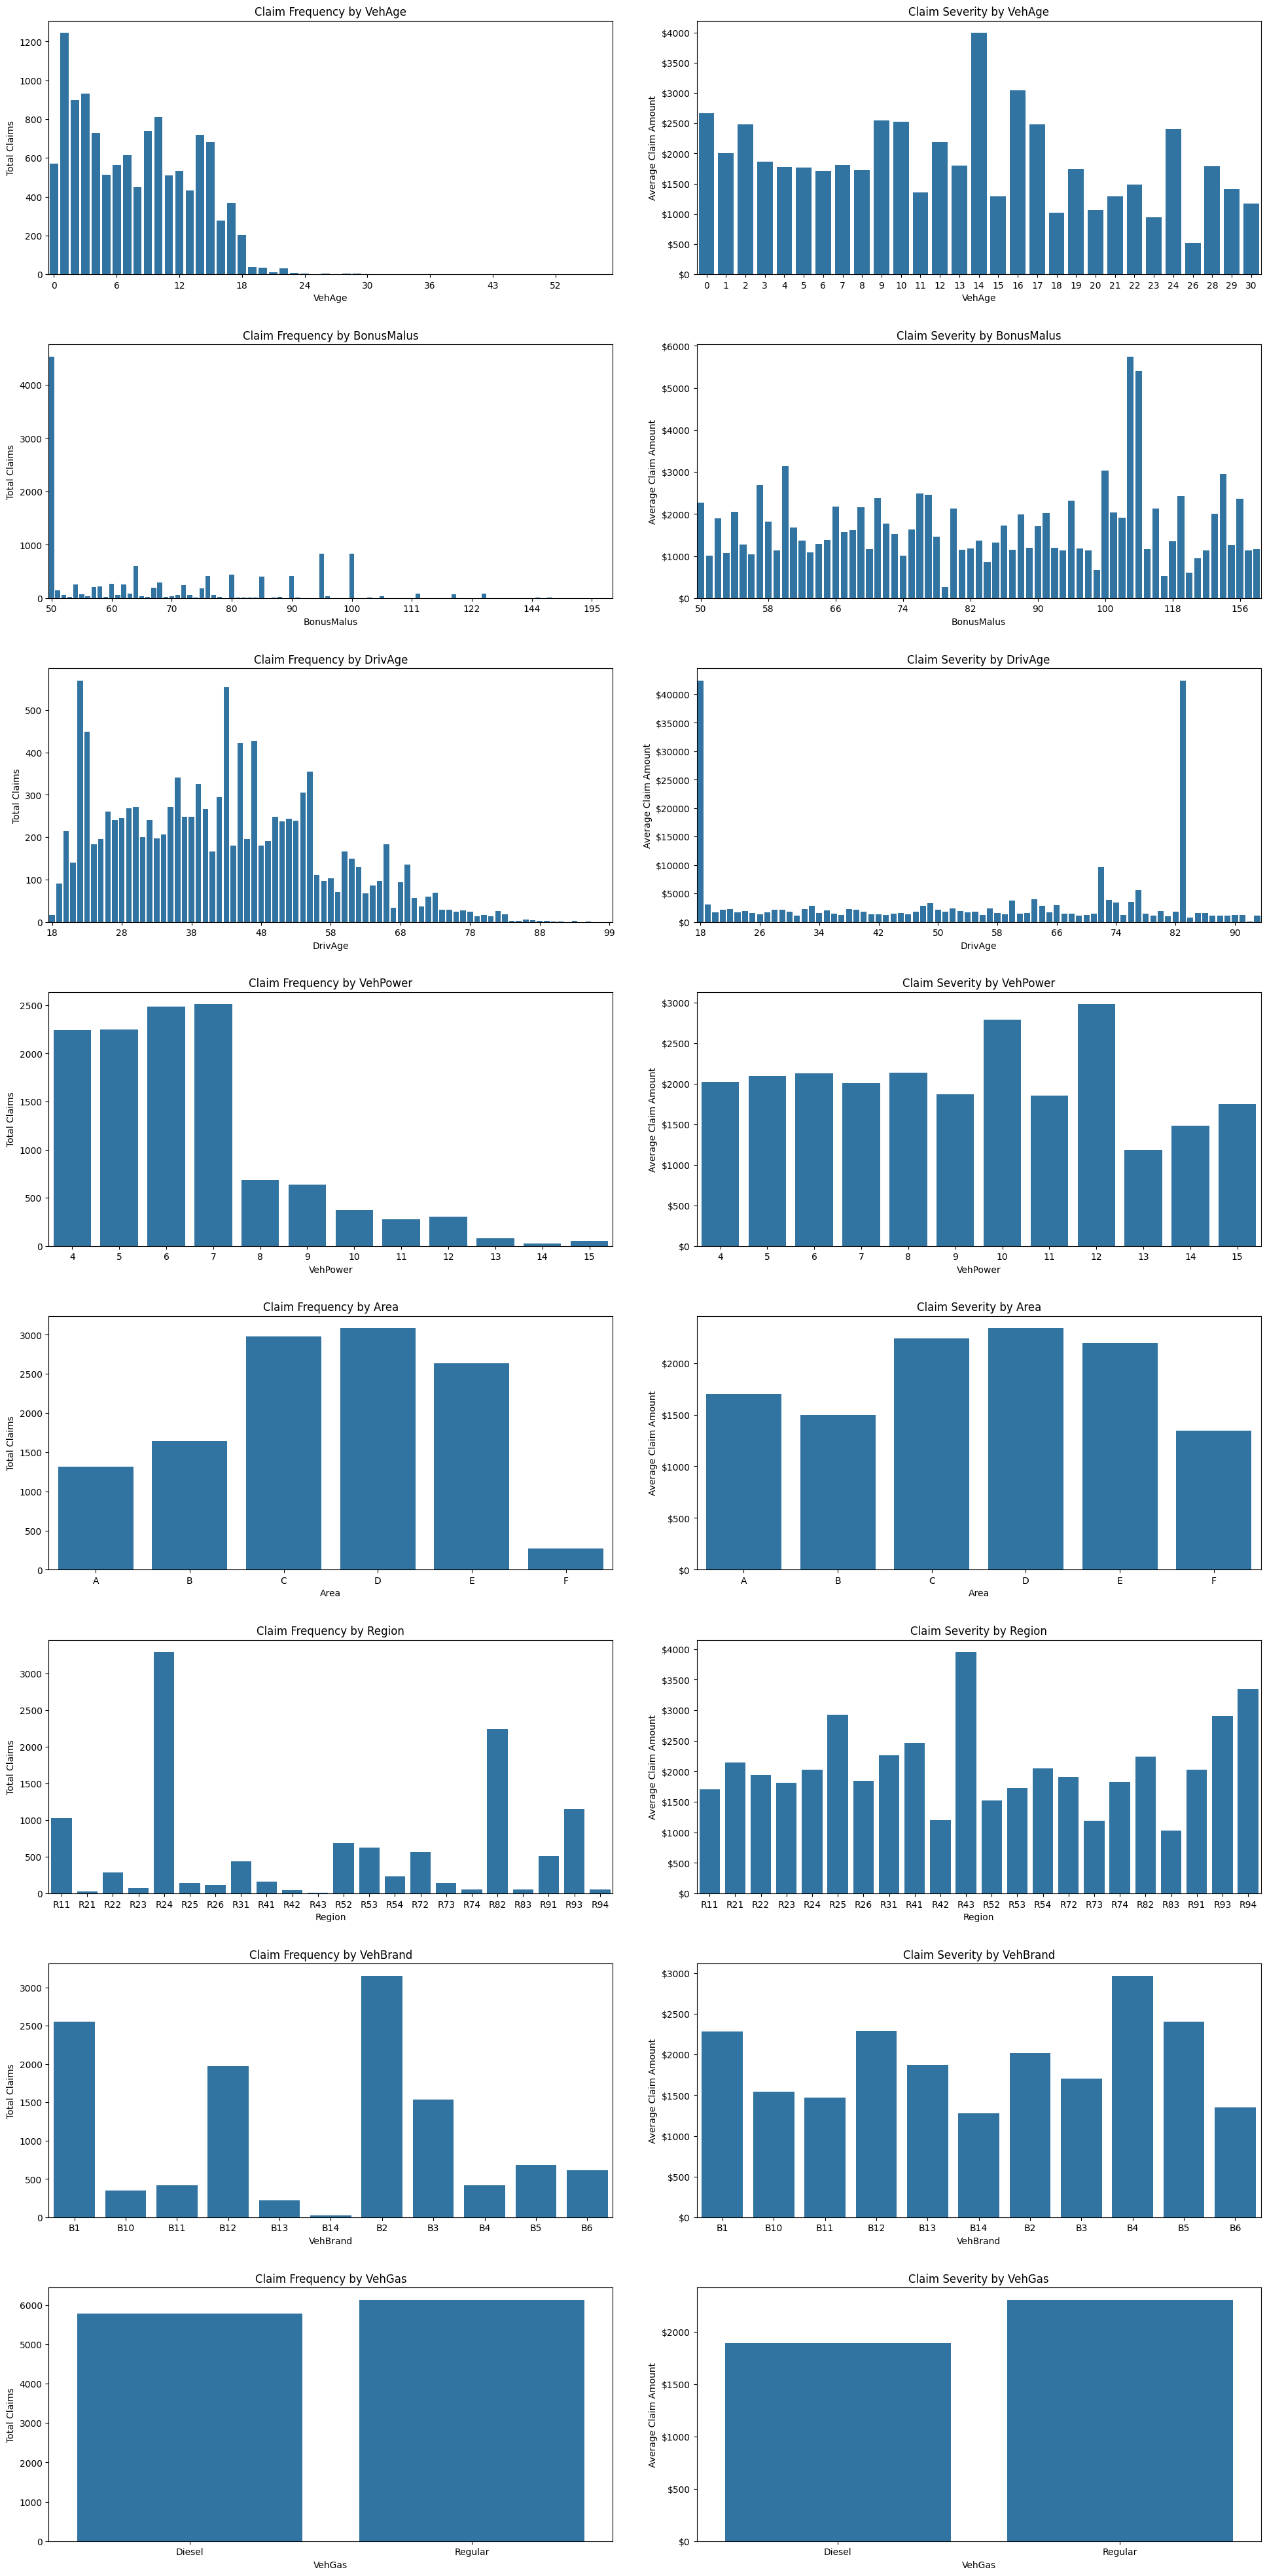

In [62]:
# Variables to plot frequency and severity of claims by policyholder characteristics
variables = ['VehAge', 'BonusMalus', 'DrivAge', 'VehPower', 'Area','Region', 'VehBrand', 'VehGas']

fig, axes = plt.subplots(nrows=len(variables), ncols=2, figsize=(20, 5 * len(variables))) 

# Loop through each variable and apply the plotting function on subplots
for idx, var in enumerate(variables):
    plot_variable(claims_data, var, axes[idx, 0], axes[idx, 1])

plt.tight_layout(pad=3.0) 
plt.show()

In [63]:
# Check for correlation between risk caracteristics
claims_data[['VehPower', 'DrivAge', 'BonusMalus', 'VehAge', 'Density']].corr()

,VehPower,DrivAge,BonusMalus,VehAge,Density
VehPower,1.000000,0.028375,-0.077144,-0.006254,0.044586
DrivAge,0.028375,1.000000,-0.480037,-0.057351,-0.005337
BonusMalus,-0.077144,-0.480037,1.000000,0.084034,0.080366
VehAge,-0.006254,-0.057351,0.084034,1.000000,-0.091280
Density,0.044586,-0.005337,0.080366,-0.091280,1.000000


In [64]:
# Get descriptive statistics from the claims data set 
descriptive_stats = claims_data.describe()
descriptive_stats

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Frequency,Severity
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,2.617735e+06,0.528057,6.460230,6.992550,45.483040,59.822980,1800.69569,76.599887,0.119194,70.764054
std,1.643394e+06,0.364232,2.055641,5.637297,14.154698,15.652541,3955.08311,1531.841302,2.141210,1448.674413
min,1.500000e+01,0.002732,4.000000,0.000000,18.000000,50.000000,2.00000,0.000000,0.000000,0.000000
25%,1.156127e+06,0.170000,5.000000,2.000000,34.000000,50.000000,94.00000,0.000000,0.000000,0.000000
50%,2.271008e+06,0.490000,6.000000,6.000000,44.000000,50.000000,399.00000,0.000000,0.000000,0.000000
75%,4.044791e+06,0.990000,7.000000,11.000000,55.000000,65.000000,1658.00000,0.000000,0.000000,0.000000
max,6.114324e+06,1.000000,15.000000,100.000000,99.000000,230.000000,27000.00000,200000.000000,365.000004,200000.000000


In [65]:
total_claims_frequency = pd.DataFrame(claims_data['Frequency'].value_counts())
total_claims_frequency

,count
Frequency,
0.000000,96335
1.000000,1247
2.000000,146
2.040816,59
4.166667,53
...,...
22.222222,1
2.597403,1
121.666668,1


In [66]:
total_claims_severity = pd.DataFrame(claims_data['Severity'].value_counts())
total_claims_severity

,count
Severity,
0.00,96335
1204.00,662
1128.12,409
1172.00,290
1128.00,96
...,...
1307.64,1
1858.81,1
741.77,1


In [67]:
# Total claims by driver's age 
total_claims_by_age_frequency = claims_data.groupby('DrivAge')['Frequency'].sum()
total_claims_by_age_severity = claims_data.groupby('DrivAge')['ClaimAmount'].sum()
total_claims_by_age_frequency = pd.DataFrame(total_claims_by_age_frequency)
total_claims_by_age_severity = pd.DataFrame(total_claims_by_age_severity)
pd.concat([total_claims_by_age_frequency, total_claims_by_age_severity], axis=1)

,Frequency,ClaimAmount
DrivAge,,
18,16.322587,211932.67
19,91.403724,82079.72
20,213.609450,91491.80
21,140.569510,87797.24
22,569.546878,113956.44
...,...,...
94,0.000000,0.00
95,1.234568,1172.00
96,0.000000,0.00


In [68]:
# Total claims by vehicle's age 
total_claims_by_vech_age_frequency = claims_data.groupby('VehAge')['Frequency'].sum()
total_claims_by_vech_age_severity = claims_data.groupby('VehAge')['ClaimAmount'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_vech_age_frequency)
total_claims_by_vech_age_severity = pd.DataFrame(total_claims_by_vech_age_severity)
pd.concat([total_claims_by_vech_age_frequency, total_claims_by_vech_age_severity], axis=1)

,Frequency,ClaimAmount
VehAge,,
0,570.358022,410632.54
1,1244.758156,605801.74
2,896.493005,776033.31
3,930.549972,508193.74
4,729.686639,441865.37
5,511.978097,384044.79
6,562.314874,351768.86
7,615.062916,395305.52
8,450.012112,378182.60


In [69]:
# Total claims by Bonus/Malus 
total_claims_by_bonus_malus_frequency = claims_data.groupby('BonusMalus')['Frequency'].sum()
total_claims_by_bonus_malus_severity = claims_data.groupby('BonusMalus')['ClaimAmount'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_bonus_malus_frequency)
total_claims_by_bonus_malus_severity = pd.DataFrame(total_claims_by_bonus_malus_severity)
pd.concat([total_claims_by_bonus_malus_frequency, total_claims_by_bonus_malus_severity], axis=1)

,Frequency,ClaimAmount
BonusMalus,,
50,4527.854394,3650556.48
51,144.747215,57993.15
52,66.867186,51447.90
53,27.815301,19397.49
54,260.253699,125119.17
...,...,...
190,0.000000,0.00
195,0.000000,0.00
196,0.000000,0.00


In [70]:
# Total claims by vechicle's power 
total_claims_by_vech_power_frequency = claims_data.groupby('VehPower')['Frequency'].sum()
total_claims_by_vech_power_severity = claims_data.groupby('VehPower')['ClaimAmount'].sum()
total_claims_by_vech_power_frequency = pd.DataFrame(total_claims_by_vech_power_frequency)
total_claims_by_vech_power_severity = pd.DataFrame(total_claims_by_vech_power_severity)
pd.concat([total_claims_by_vech_power_frequency, total_claims_by_vech_power_severity], axis=1)

,Frequency,ClaimAmount
VehPower,,
4,2241.808393,994335.45
5,2248.298384,1523507.54
6,2487.080157,1862209.18
7,2509.899334,1591878.39
8,686.681816,518985.02
9,637.763083,340514.78
10,374.189024,407308.33
11,274.163323,191014.30
12,305.273969,158011.39


# Cluster

*Catégorisation des variables*

In [71]:
# Function to perform quantile binning 
def quantile_binning_and_apply(claims_data, features, n_bins, specific_bins=None):
    bin_labels_dict = {}
    for feature in features:
        # Utiliser un nombre de bins spécifique si fourni, sinon utiliser n_bins
        bins = specific_bins.get(feature, n_bins) if specific_bins else n_bins
        bin_edges = pd.qcut(claims_data[feature], q=bins, retbins=True, duplicates='drop')[1]
        bin_edges[-1] += 1e-5
        labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]
        claims_data[f'Binned {feature}'] = pd.cut(claims_data[feature], bins=bin_edges, labels=labels, include_lowest=True, duplicates='drop')
        bin_labels_dict[f'Binned {feature}'] = labels
        print(f'Labels for {feature}: {labels}')
    return bin_labels_dict

# Treatment of BonusMalus
claims_data['Binned BonusMalus'] = claims_data['BonusMalus'].apply(lambda x: 'Bonus' if x <= 100 else 'Malus')

In [72]:
# List of features to bin 
features = ['DrivAge', 'VehAge','VehPower']
n_bins = 10

# Définir un nombre de bins spécifique pour DrivAge
specific_bins = {'DrivAge': 20}  # Par exemple, 30 bins pour DrivAge pour plus de granularité

# Call the function
bin_labels_dict = quantile_binning_and_apply(claims_data, features, n_bins, specific_bins)

Labels for DrivAge: ['18.0-25.0', '25.0-28.0', '28.0-30.0', '30.0-32.0', '32.0-34.0', '34.0-36.0', '36.0-38.0', '38.0-40.0', '40.0-42.0', '42.0-44.0', '44.0-46.0', '46.0-48.0', '48.0-51.0', '51.0-53.0', '53.0-55.0', '55.0-57.0', '57.0-61.0', '61.0-65.0', '65.0-72.0', '72.0-99.0']
Labels for VehAge: ['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-6.0', '6.0-8.0', '8.0-10.0', '10.0-12.0', '12.0-15.0', '15.0-100.0']
Labels for VehPower: ['4.0-5.0', '5.0-6.0', '6.0-7.0', '7.0-8.0', '8.0-9.0', '9.0-15.0']


*Determining the optimal amount of clusters*

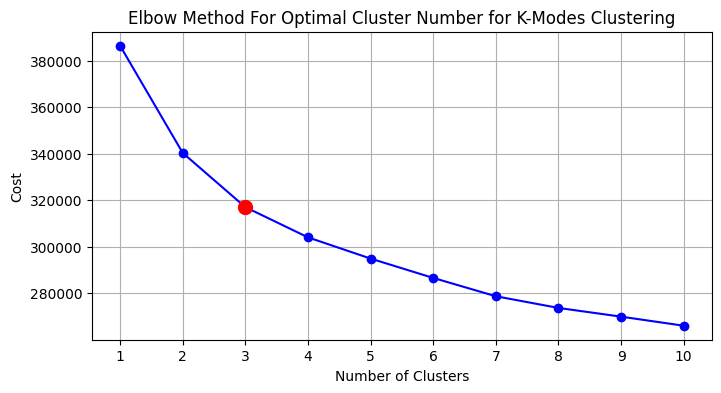

In [73]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus']

# Prepare data for one-hot encoding
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering 
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array before applying K-Modes 
data_matrix = df_categorical.to_numpy()

# Apply the elbow method to find the optimal number of clusters for K-Modes clustering method
cost = []
K = range(1, 11)  # Range of clusters to try
for num_clusters in K:
    kmodes = KModes(n_clusters=num_clusters, random_state=42)
    clusters = kmodes.fit_predict(data_matrix)
    cost.append(kmodes.cost_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(K, cost, marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Cluster Number for K-Modes Clustering')
plt.xticks(K)
plt.grid(True)

# Highlight the optimal number of clusters (3) in red 
optimal_k = 3
plt.plot(optimal_k, cost[optimal_k - 1], marker='o', markersize=10, color='r')
plt.show()

*Creating the clusters using K-Modes Clustering Method*

In [81]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus'] # See if we add more columns to improve the clustering results 

# Prepare data for categorical columns 
# Combine binned features and additional categorical columns
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns

# Convert categorical columns to category type
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array
data_matrix = df_categorical.to_numpy()

# Apply K-Modes clustering with the optimal number of clusters 
kmodes = KModes(n_clusters=3, random_state=42)

# Fit the model to the data 
clusters = kmodes.fit_predict(data_matrix)

# Store the result in 'Risk Cluster' column 
claims_data['Risk Cluster K-Mode'] = clusters

*Validate the clusters defined by the K-Modes algorithm using CatBoostClassifier*

0:	learn: 0.9590885	total: 48.6ms	remaining: 24.3s
1:	learn: 0.8522171	total: 94.8ms	remaining: 23.6s
2:	learn: 0.7631748	total: 141ms	remaining: 23.3s
3:	learn: 0.6881025	total: 182ms	remaining: 22.6s
4:	learn: 0.6271395	total: 229ms	remaining: 22.7s
5:	learn: 0.5744777	total: 273ms	remaining: 22.4s
6:	learn: 0.5302366	total: 316ms	remaining: 22.3s
7:	learn: 0.4912163	total: 358ms	remaining: 22s
8:	learn: 0.4535651	total: 402ms	remaining: 21.9s
9:	learn: 0.4194899	total: 448ms	remaining: 22s
10:	learn: 0.3890516	total: 495ms	remaining: 22s
11:	learn: 0.3618022	total: 539ms	remaining: 21.9s
12:	learn: 0.3339199	total: 585ms	remaining: 21.9s
13:	learn: 0.3095599	total: 626ms	remaining: 21.7s
14:	learn: 0.2900302	total: 668ms	remaining: 21.6s
15:	learn: 0.2721421	total: 714ms	remaining: 21.6s
16:	learn: 0.2551998	total: 761ms	remaining: 21.6s
17:	learn: 0.2394547	total: 806ms	remaining: 21.6s
18:	learn: 0.2250239	total: 858ms	remaining: 21.7s
19:	learn: 0.2109746	total: 909ms	remaining: 

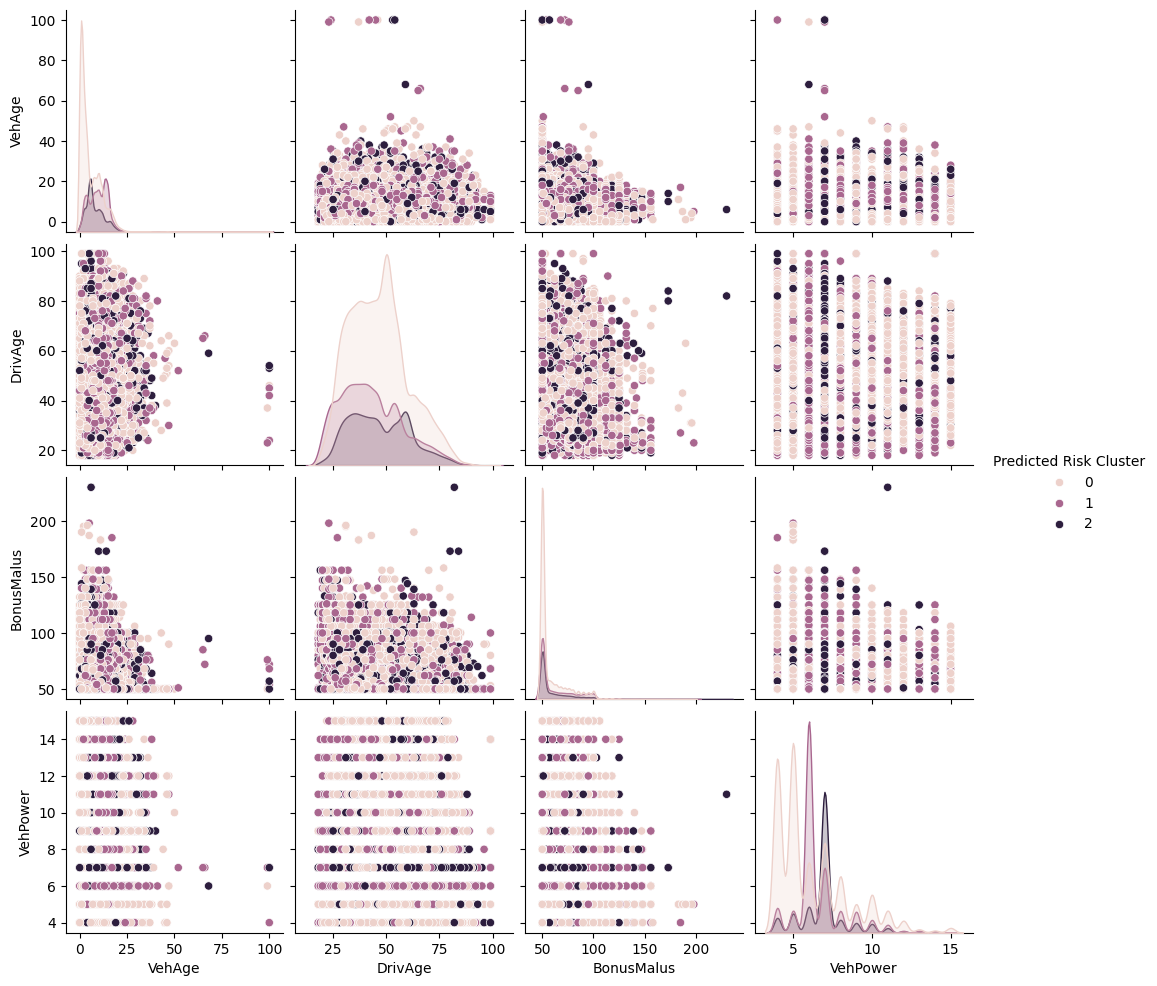

In [83]:
# Extract labels from the 'Risk Cluster' column of K-Modes clustering
labels = claims_data['Risk Cluster K-Mode']

# Identify categorical feature indices
cat_features_indices = [df_categorical.columns.get_loc(col) for col in categorical_columns]

# Split the data into training and testing sets (20% test data) and use the rest as training data (20% was the best split ratio based on GridSearchCV results optimization run)
X_train, X_test, y_train, y_test = train_test_split(df_categorical, labels, test_size=0.2, random_state=42)

# Train a CatBoost classifier with adjusted parameters
model = CatBoostClassifier(
    iterations=500,          # Number of iterations are based on GridSearchCV results optimization run to find the best parameters 
    learning_rate=0.1,      # Number of iterations are based on GridSearchCV results optimization run to find the best parameters
    depth=10,                 # Depth of the tree are based on GridSearchCV results optimization run to find the best parameters
    random_seed=42,          # Random seed for reproducibility
    cat_features=cat_features_indices # Categorical feature indices for CatBoost model to use 
    )
model.fit(X_train, y_train)

# Predict on the entire dataset to see the predicted risk clusters (Validation) 
claims_data['Predicted Risk Cluster'] = model.predict(df_categorical)

# Visualize the predicted risk clusters 
sns.pairplot(claims_data, hue='Predicted Risk Cluster', vars=['VehAge', 'DrivAge', 'BonusMalus', 'VehPower'])
plt.show()

*Cross Validation Test for Catboost predictive model*

In [80]:
# Perform cross-validation
cv_scores = cross_val_score(model, df_categorical, labels, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

0:	learn: 0.9668572	total: 54.1ms	remaining: 27s
1:	learn: 0.8694815	total: 98.9ms	remaining: 24.6s
2:	learn: 0.7872921	total: 144ms	remaining: 23.9s
3:	learn: 0.7095477	total: 190ms	remaining: 23.6s
4:	learn: 0.6436884	total: 236ms	remaining: 23.4s
5:	learn: 0.5900515	total: 281ms	remaining: 23.2s
6:	learn: 0.5447845	total: 324ms	remaining: 22.8s
7:	learn: 0.5039698	total: 367ms	remaining: 22.6s
8:	learn: 0.4679559	total: 410ms	remaining: 22.4s
9:	learn: 0.4360790	total: 453ms	remaining: 22.2s
10:	learn: 0.4032829	total: 497ms	remaining: 22.1s
11:	learn: 0.3731734	total: 543ms	remaining: 22.1s
12:	learn: 0.3497200	total: 588ms	remaining: 22s
13:	learn: 0.3238842	total: 632ms	remaining: 21.9s
14:	learn: 0.3017919	total: 690ms	remaining: 22.3s
15:	learn: 0.2823201	total: 743ms	remaining: 22.5s
16:	learn: 0.2642639	total: 791ms	remaining: 22.5s
17:	learn: 0.2464323	total: 840ms	remaining: 22.5s
18:	learn: 0.2315482	total: 885ms	remaining: 22.4s
19:	learn: 0.2170596	total: 929ms	remaining

# Interpret Clusters and Validate Clusters as Risk Groups

In [76]:
# Enconding categorical data to evaluate the clusters
encoder = OneHotEncoder()
df_categorical_encoded = encoder.fit_transform(df_categorical)

# Evaluate the clustering results using Silhouette Score
silhouette = silhouette_score(df_categorical_encoded, claims_data['Predicted Risk Cluster'])
davies_bouldin_score = davies_bouldin_score(df_categorical_encoded.toarray(), claims_data['Predicted Risk Cluster'])

print(f"Silhouette Score: {silhouette}")
print(f"Davies Bouldin Score: {davies_bouldin_score}")

KeyboardInterrupt: 

*Extraire les caractéristiques dominantes de chaque cluster : Utiliser les centroids des clusters pour comprendre les caractéristiques principales de chaque groupe.*

In [84]:
# Count the number of data points in each cluster predicted by the CatBoost model
predicted_cluster_counts = claims_data['Predicted Risk Cluster'].value_counts()
print("Number of data points in each predicted cluster:")
print(predicted_cluster_counts)

# Function to get the most frequent values (mode) for each feature in each cluster
def get_cluster_modes(df, cluster_col, feature_cols):
    cluster_modes = df.groupby(cluster_col)[feature_cols].agg(lambda x: x.mode().iloc[0])
    return cluster_modes

# Columns to analyze
feature_cols = ['Binned DrivAge', 'Binned VehAge', 'Binned VehPower', 'Area', 'VehBrand', 'Binned BonusMalus']

# Get the most frequent values for each cluster
cluster_modes = get_cluster_modes(claims_data, 'Predicted Risk Cluster', feature_cols)

# Display common characteristics for each cluster
cluster_modes

Number of data points in each predicted cluster:
Predicted Risk Cluster
0    56680
1    26313
2    17007
Name: count, dtype: int64


,Binned DrivAge,Binned VehAge,Binned VehPower,Area,VehBrand,Binned BonusMalus
Predicted Risk Cluster,,,,,,
0,48.0-51.0,0.0-1.0,4.0-5.0,C,B12,Bonus
1,18.0-25.0,12.0-15.0,5.0-6.0,D,B1,Bonus
2,57.0-61.0,4.0-6.0,6.0-7.0,E,B2,Bonus


/var/folders/xs/v3nn216s5j37yby_qfjm69940000gn/T/ipykernel_19713/2762370090.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=cluster_frequency, x='Predicted Risk Cluster', y='Frequency', palette= 'viridis')


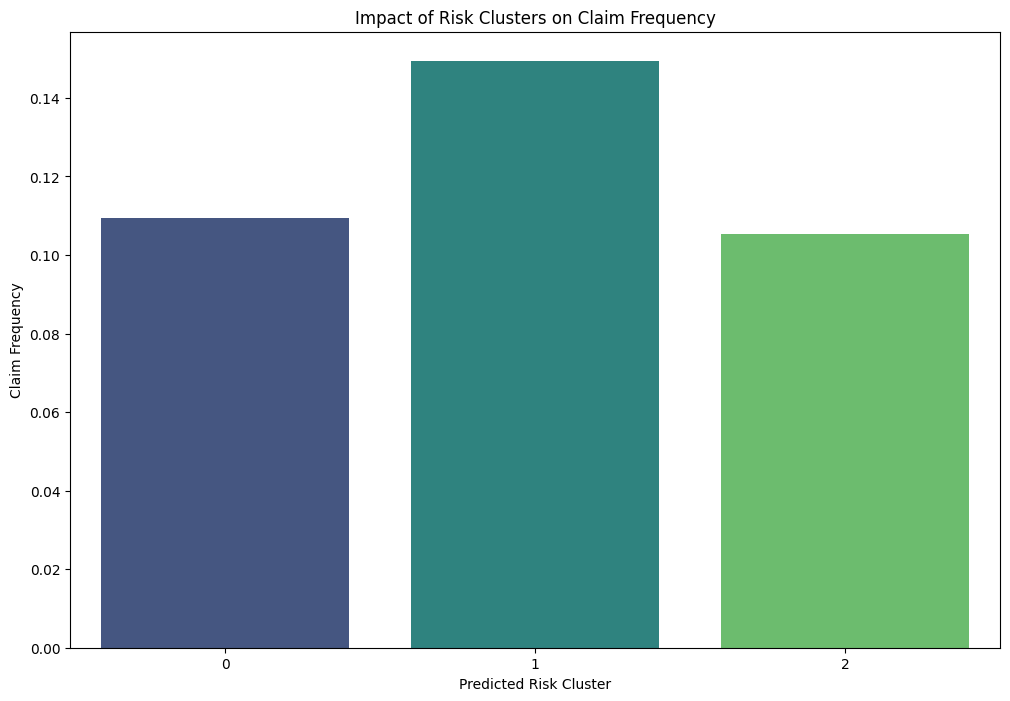

In [78]:
# Calculate the mean claim frequency for each predicted risk cluster
cluster_frequency = claims_data.groupby('Predicted Risk Cluster')['Frequency'].mean().reset_index()

# Create a bar plot to visualize the impact of each cluster on claim frequency
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=cluster_frequency, x='Predicted Risk Cluster', y='Frequency', palette= 'viridis')

plt.title('Impact of Risk Clusters on Claim Frequency')
plt.xlabel('Predicted Risk Cluster')
plt.ylabel('Claim Frequency')
plt.show()

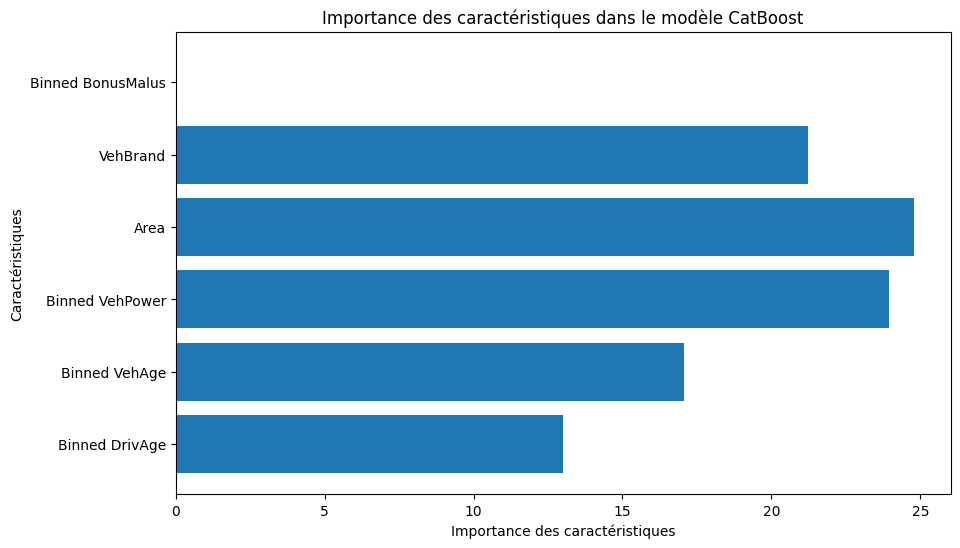

In [164]:
# CatBoost provides built-in methods to extract feature importance, which can offer insights into what features are driving the distinctions between clusters.
# Obtain which features are most important for predicting the cluster labels.
feature_importances = model.get_feature_importance()
feature_names = df_categorical.columns

# Create a bar plot to visualize the importance of each feature in the CatBoost model
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance des caractéristiques')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques dans le modèle CatBoost')
plt.show()

In [45]:
# Create DataFrames based on clusters
df_cluster_0 = claims_data[claims_data['Risk Cluster'] == 0].copy()
df_cluster_1 = claims_data[claims_data['Risk Cluster'] == 1].copy()
df_cluster_2 = claims_data[claims_data['Risk Cluster'] == 2].copy()

# Analysis of the total distribution

*AIC and BIC criterias*

In [19]:
# Fonctions de calcul de l'AIC et du BIC comme mesures de la qualité de fitting des différents modèles de distribution
def calculate_aic(n, ll, k):
    """ Calculate Akaike Information Criterion. """
    return 2 * k - 2 * ll

def calculate_bic(n, ll, k):
    """ Calculate Bayesian Information Criterion. """
    return -2 * ll + k * np.log(n)

*Distribution function for frequency*

In [20]:
def distrib_test(x, dist, params, title, dist_type):
    """ Test distribution and calculate AIC and BIC. """
    # Safe log-likelihood calculation
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

*Distribution function for severity*

In [21]:
def distrib_severity(x, dist, params, title, dist_type):
    """ Test distribution severity and calculate AIC and BIC. """
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    # Calculate AIC and BIC
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

#### Total claims

In [22]:
# Filter out zero claim amounts for severity analysis
claim_counts = claims_data['Frequency']
non_zero_claims = claims_data[claims_data['Severity'] > 0]['Severity']

*Frequency*

In [23]:
# Poisson Distribution Fitting
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
distrib_test(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials = 1  # This should be adjusted based on your specific scenario
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
distrib_test(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
mean_claims = np.mean(claim_counts)
var_claims = np.var(claim_counts, ddof=1)

if var_claims > mean_claims:
    r_negbin = (mean_claims ** 2) / (var_claims - mean_claims)
    p_negbin = r_negbin / (r_negbin + mean_claims)
    params_negbin = [r_negbin, p_negbin]

    # Fit check with your distribution testing function
    distrib_test(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')
else:
    print("The variance must be greater than the mean for fitting a negative binomial.")

AIC for Fit with Poisson Distribution: 133832.56732566294
BIC for Fit with Poisson Distribution: 133842.08025112792
AIC for Fit with Binomial Distribution: 141115.09246842703
BIC for Fit with Binomial Distribution: 141134.11831935696
AIC for Fit with Negative Binomial Distribution: 120200.78647043131
BIC for Fit with Negative Binomial Distribution: 120219.81232136126


*Severity*

In [24]:
# Log-normal fitting for severity 
shape, loc, scale = lognorm.fit(non_zero_claims)
params_lognorm = [shape, loc, scale]
distrib_severity(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b, loc_pareto, scale_pareto = pareto.fit(non_zero_claims)  # Fitting with floc set to 0
params_pareto = [b, loc_pareto, scale_pareto]
distrib_severity(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha, loc_gamma, beta = gamma.fit(non_zero_claims)  # Adjusting fit parameters with floc set to 0 
params_gamma = [alpha, loc_gamma, beta]
distrib_severity(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 61011.03355955744
BIC for Fit with Log-normal Distribution: 61029.653310400405
AIC for Fit with Pareto Distribution: 61251.71150028282
BIC for Fit with Pareto Distribution: 61270.33125112578
AIC for Fit with Gamma Distribution: 167970.14982245426
BIC for Fit with Gamma Distribution: 167988.76957329724


**Cluster 0**

In [25]:
# Filter out zero claim amounts for severity analysis 
claim_counts_0 = df_cluster_0['Frequency']
non_zero_claims_0 = df_cluster_0[df_cluster_0['Severity'] > 0]['Severity']

*Frequency*

In [26]:
# Poisson Distribution Fitting
lambda_poisson_0 = np.mean(claim_counts_0)
params_poisson_0 = [lambda_poisson_0]
distrib_test(claim_counts_0, poisson, params_poisson_0, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials_0 = 1  # This should be adjusted based on your specific scenario
p_success_0 = np.mean(claim_counts_0) / n_trials_0
params_binom_0 = [n_trials_0, p_success_0]
distrib_test(claim_counts_0, binom, params_binom_0, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
mean_claims_0 = np.mean(claim_counts_0)
var_claims_0 = np.var(claim_counts_0)
if var_claims_0 > mean_claims_0:
    r_negbin_0 = (mean_claims_0 ** 2) / (var_claims_0 - mean_claims_0)
    p_negbin_0 = r_negbin_0 / (r_negbin_0 + mean_claims_0)
    params_negbin_0 = [r_negbin_0, p_negbin_0]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_0, nbinom, params_negbin_0, 'Fit with Negative Binomial Distribution', dist_type='discrete')
else:
    print("The variance must be greater than the mean for fitting a negative binomial.")


AIC for Fit with Poisson Distribution: 93311.16800311534
BIC for Fit with Poisson Distribution: 93320.31304823252
AIC for Fit with Binomial Distribution: 98567.02420875787
BIC for Fit with Binomial Distribution: 98585.31429899225
AIC for Fit with Negative Binomial Distribution: 84582.38325246025
BIC for Fit with Negative Binomial Distribution: 84600.67334269463


*Severity*

In [27]:
# Log-normal fitting
# Log-normal fitting
shape_0, loc_0, scale_0 = lognorm.fit(non_zero_claims_0)
params_lognorm_0 = [shape_0, loc_0, scale_0]
distrib_severity(non_zero_claims_0, lognorm, params_lognorm_0, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_0, loc_pareto_0, scale_pareto_0 = pareto.fit(non_zero_claims_0)  # Fitting with floc_0 set to 0
params_pareto_0 = [b_pareto_0, loc_pareto_0, scale_pareto_0]
distrib_severity(non_zero_claims_0, pareto, params_pareto_0, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_0, loc_gamme_0, beta_0 = gamma.fit(non_zero_claims_0)  # Adjusting fit parameters as needed
params_gamma_0 = [alpha_0, loc_gamme_0, beta_0]
distrib_severity(non_zero_claims_0, gamma, params_gamma_0, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 45605.48740586823
BIC for Fit with Log-normal Distribution: 45623.24110762722
AIC for Fit with Pareto Distribution: 45698.36417592401
BIC for Fit with Pareto Distribution: 45716.117877683
AIC for Fit with Gamma Distribution: 125766.14628310058
BIC for Fit with Gamma Distribution: 125783.89998485956


**Cluster 1**

In [28]:
# Filter out zero claim amounts for severity analysis 
claim_counts_1 = df_cluster_1['Frequency']
non_zero_claims_1 = df_cluster_1[df_cluster_1['Severity'] > 0]['Severity']

*Frequency*

In [29]:
claim_counts_1 = df_cluster_1['Frequency']

# Poisson Distribution Fitting
lambda_poisson_1 = np.mean(claim_counts_1)
params_poisson_1 = [lambda_poisson_1]
distrib_test(claim_counts_1, poisson, params_poisson_1, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials_1 = 1  # This should be adjusted based on your specific scenario
p_success_1 = np.mean(claim_counts_1) / n_trials_1
params_binom_1 = [n_trials_1, p_success_1]
distrib_test(claim_counts_1, binom, params_binom_1, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin_1 = (np.mean(claim_counts_1)**2) / (np.var(claim_counts_1) - np.mean(claim_counts_1))
p_negbin_1 = r_negbin_1 / (r_negbin_1 + np.mean(claim_counts_1))
params_negbin_1 = [r_negbin_1, p_negbin_1]
distrib_test(claim_counts_1, nbinom, params_negbin_1, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 4980.9381926538545
BIC for Fit with Poisson Distribution: 4985.978729044071
AIC for Fit with Binomial Distribution: 5696.0118507246625
BIC for Fit with Binomial Distribution: 5706.092923505094
AIC for Fit with Negative Binomial Distribution: 4717.92868132271
BIC for Fit with Negative Binomial Distribution: 4728.009754103142


*Severity*

In [30]:
# Log-normal fitting
shape_1, loc_1, scale_1 = lognorm.fit(non_zero_claims_1)
params_lognorm_1 = [shape_1, loc_1, scale_1]
distrib_severity(non_zero_claims_1, lognorm, params_lognorm_1, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_1, loc_pareto_1, scale_pareto_1 = pareto.fit(non_zero_claims_1)  # Fitting with floc set to 0
params_pareto_1 = [b_pareto_1, loc_pareto_1, scale_pareto_1]
distrib_severity(non_zero_claims_1, pareto, params_pareto_1, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_1, loc_gamma_1, beta_1 = gamma.fit(non_zero_claims_1)  # Adjusting fit parameters as needed
params_gamma_1 = [alpha_1, loc_gamma_1, beta_1]
distrib_severity(non_zero_claims_1, gamma, params_gamma_1, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 2630.087641049742
BIC for Fit with Log-normal Distribution: 2639.2563784657873
AIC for Fit with Pareto Distribution: 2672.849978736416
BIC for Fit with Pareto Distribution: 2682.018716152461
AIC for Fit with Gamma Distribution: 7138.077879049448
BIC for Fit with Gamma Distribution: 7147.2466164654925


**Cluster 2**

In [31]:
# Filter out zero claim amounts for severity analysis 
claim_counts_2 = df_cluster_2['Frequency']
non_zero_claims_2 = df_cluster_2[df_cluster_2['Severity'] > 0]['Severity']

*Frequency*

In [32]:
# Poisson Distribution Fitting
lambda_poisson_2 = np.mean(claim_counts_2)
params_poisson_2 = [lambda_poisson_2]
distrib_test(claim_counts_2, poisson, params_poisson_2, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials_2 = 1  # This should be adjusted based on your specific scenario
p_success_2 = np.mean(claim_counts_2) / n_trials_2
params_binom_2 = [n_trials_2, p_success_2]
distrib_test(claim_counts_2, binom, params_binom_2, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin_2 = (np.mean(claim_counts_2)**2) / (np.var(claim_counts_2) - np.mean(claim_counts_2))
p_negbin_2 = r_negbin_2 / (r_negbin_2 + np.mean(claim_counts_2))
params_negbin_2 = [r_negbin_2, p_negbin_2]
distrib_test(claim_counts_2, nbinom, params_negbin_2, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 35296.210971008026
BIC for Fit with Poisson Distribution: 35304.50778360877
AIC for Fit with Binomial Distribution: 36705.76268100254
BIC for Fit with Binomial Distribution: 36722.35630620404
AIC for Fit with Negative Binomial Distribution: 30397.479054328884
BIC for Fit with Negative Binomial Distribution: 30414.072679530385


*Severity*

In [33]:
# Log-normal fitting
shape_2, loc_2, scale_2 = lognorm.fit(non_zero_claims_2)
params_lognorm_2 = [shape_2, loc_2, scale_2]
distrib_severity(non_zero_claims_2, lognorm, params_lognorm_2, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_2, loc_pareto_2, scale_pareto_2 = pareto.fit(non_zero_claims_2)  # Fitting with floc_2 set to 0
params_pareto_2 = [b_pareto_2, loc_pareto_2, scale_pareto_2]
distrib_severity(non_zero_claims_2, pareto, params_pareto_2, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_2, loc_gamma_2, beta_2 = gamma.fit(non_zero_claims_2)  # Adjusting fit parameters as needed
params_gamma_2 = [alpha_2, loc_gamma_2, beta_2]
distrib_severity(non_zero_claims_2, gamma, params_gamma_2, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 12735.349357875035
BIC for Fit with Log-normal Distribution: 12749.257197542094
AIC for Fit with Pareto Distribution: 12867.327922435043
BIC for Fit with Pareto Distribution: 12881.235762102102
AIC for Fit with Gamma Distribution: 34910.14154356486
BIC for Fit with Gamma Distribution: 34924.04938323192


*Premium exceedance formula*

In [34]:
def check_premium_exceedance(results, adj_premium, n_sim, n_pol):
    """
    Checks if the adjusted premium meets the criterion of less than 0.5% claim exceedance per simulation.

    Parameters:
    results (DataFrame): DataFrame containing simulation results with columns 'Simulation' and 'Total_Claim_Severity'
    adj_premium (float): The calculated premium threshold to test against
    n_sim (int): The number of simulations
    n_pol (int): The number of policies per simulation

    Returns:
    dict: A dictionary with the threshold check result, average exceedance percentage, and a DataFrame of exceedance percentages per simulation
    """
    
    exceeds_premium_count = []

    # Loop through each simulation to count policies with total claims exceeding the premium
    for i in range(n_sim):
        # Filter data for the current simulation
        simulation_data = results[results['Simulation'] == i]
        
        # Count policies where total claim severity exceeds the calculated premium
        exceed_count = (simulation_data['Premium_per_policy'] > adj_premium).sum()
        
        # Calculate the percentage of policies exceeding the premium in this simulation
        exceed_percentage = exceed_count / n_pol * 100
        exceeds_premium_count.append(exceed_percentage)

    # Convert results to a DataFrame for easy analysis
    exceeds_premium_df = pd.DataFrame({
        'Simulation': range(n_sim),
        'Exceed_Percentage': exceeds_premium_count
    })

    # Check if the exceedance percentage is below 0.5% for each simulation
    all_below_threshold = (exceeds_premium_df['Exceed_Percentage'] < 0.5).all()
    average_exceed_percentage = exceeds_premium_df['Exceed_Percentage'].mean()

    # Print results
    print("Does the premium meet the 0.5% threshold in all simulations?:", all_below_threshold)
    print("Average exceedance percentage across simulations:", average_exceed_percentage)
    print("Exceedance percentages per simulation:\n", exceeds_premium_df)

    return {
        "all_below_threshold": all_below_threshold,
        "average_exceed_percentage": average_exceed_percentage,
        "exceedance_df": exceeds_premium_df
    }

*Total claims*

In [35]:
# Monte carlo simulation for ALL CLAIMS
np.random.seed(23)

# Parameters
n_simulations = 100
n_policies = len(claims_data)  # Replace with len(claims_data) if claims_data is defined

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs = []

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once (Frequency per year per policy)
    frequency = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Create a severity matrix for policies with claims
    max_claim = frequency.max()  # Max number of claims across policies
    severity_matrix = np.zeros((n_policies, max_claim))
    
    # Generate severities per policy based on the number of claims (frequency)
    for policy_idx in range(n_policies):
        claim_count = frequency[policy_idx]
        if claim_count > 0:
            severity_matrix[policy_idx, :claim_count] = lognorm.rvs(
                shape, loc=0, scale=scale, size=claim_count
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity = np.sum(severity_matrix, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df = pd.DataFrame({
        'Policy': np.arange(n_policies),
        'Frequency': frequency,
        'Premium_per_policy': Total_claim_severity,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs.append(temp_df)

# Concatenate all temporary DataFrames at once for better performance
simulation_results = pd.concat(simulation_dfs, ignore_index=True)


# Compute the sum of all claims (total loss) for each simulation
premium_per_simulation = simulation_results.groupby('Simulation')['Premium_per_policy'].mean()

# We chose the median to not be influenced by outliers, if any
average_premium = premium_per_simulation.mean()

average_premium

200.9470920160547

In [63]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium = scoreatpercentile(simulation_results['Premium_per_policy'], 99.55)

# Output the adjusted premium
print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium)

Adjusted Premium (99.5th percentile constraint): 10295.785630671868


In [64]:
result = check_premium_exceedance(simulation_results, adjusted_premium, n_simulations, n_policies)

# Access the results
all_below_threshold = result["all_below_threshold"]
average_exceed_percentage = result["average_exceed_percentage"]
exceedance_df = result["exceedance_df"]

Does the premium meet the 0.5% threshold in all simulations?: True
Average exceedance percentage across simulations: 0.45
Exceedance percentages per simulation:
     Simulation  Exceed_Percentage
0            0              0.461
1            1              0.460
2            2              0.444
3            3              0.455
4            4              0.469
..         ...                ...
95          95              0.446
96          96              0.457
97          97              0.470
98          98              0.468
99          99              0.470

[100 rows x 2 columns]


# Monte carlo per cluster

*Cluster 0*

In [36]:
# Monte carlo simulation for cluster 0
np.random.seed(24)

# Parameters
n_simulations_0 = 100
n_policies_0 = len(df_cluster_0)  # Replace with len(claims_data) if claims_data is defined

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_0 = []

# Monte Carlo simulation loop
for i in range(n_simulations_0):
    # Simulate number of claims for all policies at once (Frequency_0 per year per policy)
    frequency_0 = nbinom.rvs(r_negbin_0, p_negbin_0, size=n_policies_0)
    
    # Create a severity matrix for policies with claims
    max_claim_0 = frequency_0.max()  # Max number of claims across policies
    severity_matrix_0 = np.zeros((n_policies_0, max_claim_0))
    
    # Generate severities per policy based on the number of claims (frequency_0)
    for policy_idx in range(n_policies_0):
        claim_count_0 = frequency_0[policy_idx]
        if claim_count_0 > 0:
            severity_matrix_0[policy_idx, :claim_count_0] = lognorm.rvs(
                shape_0, loc=0, scale=scale_0, size=claim_count_0
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_0 = np.sum(severity_matrix_0, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_0 = pd.DataFrame({
        'Policy': np.arange(n_policies_0),
        'Frequency': frequency_0,
        'Premium_per_policy': Total_claim_severity_0,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_0.append(temp_df_0)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_0 = pd.concat(simulation_dfs_0, ignore_index=True)


# Compute the sum of all claims (total loss) for each simulation
premium_per_simulation_0 = simulation_results_0.groupby('Simulation')['Premium_per_policy'].mean()

average_premium_0 = premium_per_simulation_0.mean()

average_premium_0


203.8134166722232

In [66]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium_0 = scoreatpercentile(simulation_results_0['Premium_per_policy'], 99.55)

# Output the adjusted premium
print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium_0)

Adjusted Premium (99.5th percentile constraint): 6984.673119759496


In [67]:
result_0 = check_premium_exceedance(simulation_results_0, adjusted_premium_0, n_simulations_0, n_policies_0)

# Access the results
all_below_threshold_0 = result_0["all_below_threshold"]
average_exceed_percentage_0 = result_0["average_exceed_percentage"]
exceedance_df_0 = result_0["exceedance_df"]

Does the premium meet the 0.5% threshold in all simulations?: False
Average exceedance percentage across simulations: 0.45
Exceedance percentages per simulation:
     Simulation  Exceed_Percentage
0            0           0.476359
1            1           0.423430
2            2           0.434016
3            3           0.416373
4            4           0.471066
..         ...                ...
95          95           0.479887
96          96           0.460480
97          97           0.441073
98          98           0.441073
99          99           0.451658

[100 rows x 2 columns]


*Cluster 1*

In [37]:
# Monte carlo simulation for cluster 1
np.random.seed(25)

# Parameters
n_simulations_1 = 100
n_policies_1 = len(df_cluster_1)  # Replace with len(claims_data) if claims_data is defined

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_1 = []

# Monte Carlo simulation loop
for i in range(n_simulations_1):
    # Simulate number of claims for all policies at once (Frequency_1 per year per policy)
    frequency_1 = nbinom.rvs(r_negbin_1, p_negbin_1, size=n_policies_1)
    
    # Create a severity matrix for policies with claims
    max_claim_1 = frequency_1.max()  # Max number of claims across policies
    severity_matrix_1 = np.zeros((n_policies_1, max_claim_1))
    
    # Generate severities per policy based on the number of claims (frequency_1)
    for policy_idx in range(n_policies_1):
        claim_count_1 = frequency_1[policy_idx]
        if claim_count_1 > 0:
            severity_matrix_1[policy_idx, :claim_count_1] = lognorm.rvs(
                shape_1, loc=0, scale=scale_1, size=claim_count_1
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_1 = np.sum(severity_matrix_1, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_1 = pd.DataFrame({
        'Policy': np.arange(n_policies_1),
        'Frequency': frequency_1,
        'Premium_per_policy': Total_claim_severity_1,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_1.append(temp_df_1)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_1 = pd.concat(simulation_dfs_1, ignore_index=True)


# Compute the sum of all claims (total loss) for each simulation
premium_per_simulation_1 = simulation_results_1.groupby('Simulation')['Premium_per_policy'].mean()

average_premium_1 = premium_per_simulation_1.mean()

average_premium_1

537.6700172973652

*Cluster 2*

In [38]:
# Monte carlo simulation for cluster 2
np.random.seed(26)

# Parameters
n_simulations_2 = 100
n_policies_2 = len(df_cluster_2)  # Replace with len(claims_data) if claims_data is defined

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_2 = []

# Monte Carlo simulation loop
for i in range(n_simulations_2):
    # Simulate number of claims for all policies at once (Frequency_2 per year per policy)
    frequency_2 = nbinom.rvs(r_negbin_2, p_negbin_2, size=n_policies_2)
    
    # Create a severity matrix for policies with claims
    max_claim_2 = frequency_2.max()  # Max number of claims across policies
    severity_matrix_2 = np.zeros((n_policies_2, max_claim_2))
    
    # Generate severities per policy based on the number of claims (frequency_2)
    for policy_idx in range(n_policies_2):
        claim_count_2 = frequency_2[policy_idx]
        if claim_count_2 > 0:
            severity_matrix_2[policy_idx, :claim_count_2] = lognorm.rvs(
                shape_2, loc=0, scale=scale_2, size=claim_count_2
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_2 = np.sum(severity_matrix_2, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_2 = pd.DataFrame({
        'Policy': np.arange(n_policies_2),
        'Frequency': frequency_2,
        'Premium_per_policy': Total_claim_severity_2,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_2.append(temp_df_2)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_2 = pd.concat(simulation_dfs_2, ignore_index=True)


# Compute the sum of all claims (total loss) for each simulation
premium_per_simulation_2 = simulation_results_2.groupby('Simulation')['Premium_per_policy'].mean()

average_premium_2 = premium_per_simulation_2.mean()

average_premium_2

176.9010106632726